In [1]:
%matplotlib inline


# JPDA vs JPDA with EHM



In this notebook, we compare the performance of the standard JPDA implementation [1], which exhaustively enumerates all joint hypotheses, to a fast implementation of JPDA, which makes use of Efficient Hypothesis Management (EHM) [2].



Simulate ground truth
---------------------
As with the [JPDA tutorial](https://stonesoup.readthedocs.io/en/v0.1b6/auto_tutorials/08_JPDATutorial.html), we simulate two targets moving in the
positive x, y cartesian plane (intersecting approximately half-way through their transition).
We then add truth detections with clutter at each time-step.



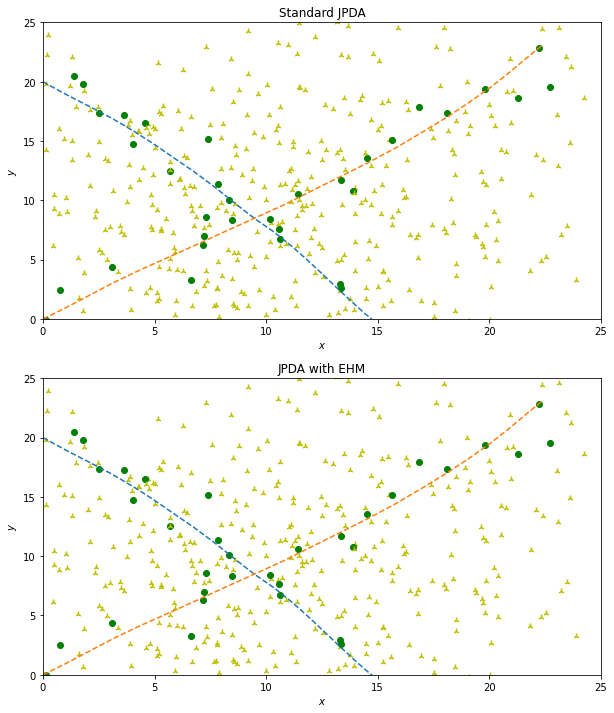

In [2]:
from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import uniform

from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel, \
                                               ConstantVelocity
from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState
from stonesoup.types.detection import TrueDetection
from stonesoup.types.detection import Clutter
from stonesoup.models.measurement.linear import LinearGaussian

# np.random.seed(1991)

truths = set()

start_time = datetime.now()
transition_model = CombinedLinearGaussianTransitionModel([ConstantVelocity(0.005),
                                                          ConstantVelocity(0.005)])

truth = GroundTruthPath([GroundTruthState([0, 1, 0, 1], timestamp=start_time)])
for k in range(1, 21):
    truth.append(GroundTruthState(
        transition_model.function(truth[k-1], noise=True, time_interval=timedelta(seconds=1)),
        timestamp=start_time+timedelta(seconds=k)))
truths.add(truth)

truth = GroundTruthPath([GroundTruthState([0, 1, 20, -1], timestamp=start_time)])
for k in range(1, 21):
    truth.append(GroundTruthState(
        transition_model.function(truth[k-1], noise=True, time_interval=timedelta(seconds=1)),
        timestamp=start_time+timedelta(seconds=k)))
truths.add(truth)

multi_fig = plt.figure(figsize=(10, 12))
axm = multi_fig.add_subplot(2, 1, 1)
axm.set_xlabel("$x$")
axm.set_ylabel("$y$")
axm.set_ylim(0, 25)
axm.set_xlim(0, 25)
axm.set_title("Standard JPDA")

axm2 = multi_fig.add_subplot(2, 1, 2)
axm2.set_xlabel("$x$")
axm2.set_ylabel("$y$")
axm2.set_ylim(0, 25)
axm2.set_xlim(0, 25)
axm2.set_title("JPDA with EHM")

# Plot ground truth.
for truth in truths:
    axm.plot([state.state_vector[0] for state in truth],
             [state.state_vector[2] for state in truth],
             linestyle="--",)
    axm2.plot([state.state_vector[0] for state in truth],
             [state.state_vector[2] for state in truth],
             linestyle="--", )

# Generate measurements.
all_measurements = []

measurement_model = LinearGaussian(
    ndim_state=4,
    mapping=(0, 2),
    noise_covar=np.array([[0.75, 0],
                          [0, 0.75]])
    )

prob_detect = 0.9  # 90% chance of detection.

for k in range(20):
    measurement_set = set()

    for truth in truths:
        # Generate actual detection from the state with a 10% chance that no detection is received.
        if np.random.rand() <= prob_detect:
            measurement = measurement_model.function(truth[k], noise=True)
            measurement_set.add(TrueDetection(state_vector=measurement,
                                              groundtruth_path=truth,
                                              timestamp=truth[k].timestamp))

        # Generate clutter at this time-step
        truth_x = truth[k].state_vector[0]
        truth_y = truth[k].state_vector[2]
        for _ in range(np.random.randint(30)):
            x = uniform.rvs(truth_x - 10, 20)
            y = uniform.rvs(truth_y - 10, 20)
            measurement_set.add(Clutter(np.array([[x], [y]]), timestamp=truth[k].timestamp))
    all_measurements.append(measurement_set)

# Plot measurements.
for set_ in all_measurements:
    # Plot actual detections.
    axm.scatter([state.state_vector[0] for state in set_ if isinstance(state, TrueDetection)],
                [state.state_vector[1] for state in set_ if isinstance(state, TrueDetection)],
                color='g')
    # Plot clutter.
    axm.scatter([state.state_vector[0] for state in set_ if isinstance(state, Clutter)],
                [state.state_vector[1] for state in set_ if isinstance(state, Clutter)],
                color='y',
                marker='2')
    # Plot actual detections.
    axm2.scatter([state.state_vector[0] for state in set_ if isinstance(state, TrueDetection)],
                [state.state_vector[1] for state in set_ if isinstance(state, TrueDetection)],
                color='g')
    # Plot clutter.
    axm2.scatter([state.state_vector[0] for state in set_ if isinstance(state, Clutter)],
                [state.state_vector[1] for state in set_ if isinstance(state, Clutter)],
                color='y',
                marker='2')

## Predictor and Updater

In [3]:
from stonesoup.predictor.kalman import KalmanPredictor
predictor = KalmanPredictor(transition_model)

In [4]:
from stonesoup.updater.kalman import KalmanUpdater
updater = KalmanUpdater(measurement_model)

## Hypothesiser

Initial hypotheses are calculated (per track) in the same manner as the PDA.
Therefore, in Stone Soup, the JPDA filter uses the :class:`~.PDAHypothesiser` to create these
hypotheses.
Unlike the :class:`~.PDA` data associator, in Stone Soup, the :class:`~.JPDA` associator takes
this collection of hypotheses and adjusts their weights according to the method described above,
before returning key-value pairs of tracks and detections to be associated with them.



In [5]:
from stonesoup.hypothesiser.probability import PDAHypothesiser
# This doesn't need to be created again, but for the sake of visualising the process, it has been
# added.
hypothesiser = PDAHypothesiser(predictor=predictor,
                               updater=updater,
                               clutter_spatial_density=0.125,
                               prob_detect=prob_detect)

## Metrics 

In [6]:
from stonesoup.metricgenerator.manager import SimpleManager
from stonesoup.metricgenerator.ospametric import OSPAMetric
from stonesoup.measures import Euclidean

ospa_generator = OSPAMetric(c=10, p=1, measure=Euclidean([0, 2]))

# Metric manager for standard JPDA
metric_manager_jpda = SimpleManager([ospa_generator])

# Metric manager for JPDA with EHM
metric_manager_jpda_ehm = SimpleManager([ospa_generator])

## Priors

In [7]:
from stonesoup.types.state import GaussianState
from stonesoup.types.track import Track

prior1 = GaussianState([[0], [1], [0], [1]], np.diag([1.5, 0.5, 1.5, 0.5]), timestamp=start_time)
prior2 = GaussianState([[0], [1], [20], [-1]], np.diag([1.5, 0.5, 1.5, 0.5]), timestamp=start_time)

# Track priors for standard JPDA
tracks_jpda = {Track([prior1]), Track([prior2])}

# Track priors for JPDA with EHM
tracks_jpda_ehm = {Track([prior1]), Track([prior2])}

Running the standard JPDA filter
-----------------------



In [8]:
from stonesoup.types.array import StateVectors
from stonesoup.functions import gm_reduce_single
from stonesoup.types.update import GaussianStateUpdate
from stonesoup.dataassociator.probability import JPDA

data_associator = JPDA(hypothesiser=hypothesiser)

s = datetime.now()
for n, measurements in enumerate(all_measurements):
    hypotheses = data_associator.associate(tracks_jpda,
                                           measurements,
                                           start_time + timedelta(seconds=n))

    # Loop through each track, performing the association step with weights adjusted according to
    # JPDA.
    for track in tracks_jpda:
        track_hypotheses = hypotheses[track]

        posterior_states = []
        posterior_state_weights = []
        for hypothesis in track_hypotheses:
            if not hypothesis:
                posterior_states.append(hypothesis.prediction)
            else:
                posterior_state = updater.update(hypothesis)
                posterior_states.append(posterior_state)
            posterior_state_weights.append(hypothesis.probability)

        means = StateVectors([state.state_vector for state in posterior_states])
        covars = np.stack([state.covar for state in posterior_states], axis=2)
        weights = np.asarray(posterior_state_weights)

        # Reduce mixture of states to one posterior estimate Gaussian.
        post_mean, post_covar = gm_reduce_single(means, covars, weights)

        # Add a Gaussian state approximation to the track.
        track.append(GaussianStateUpdate(
            post_mean, post_covar,
            track_hypotheses,
            track_hypotheses[0].measurement.timestamp))
    
    metric_manager_jpda.add_data(
        truths, tracks_jpda, measurements,
        overwrite=False,  # Don't overwrite, instead add above as additional data
    )
diff_jpda = datetime.now() - s

Running the JPDA with EHM filter
------------------------------------------------



In [9]:
from stonesoup.plugins.ehm import JPDAWithEHM

data_associator = JPDAWithEHM(hypothesiser=hypothesiser)

s = datetime.now()
for n, measurements in enumerate(all_measurements):
    hypotheses = data_associator.associate(tracks_jpda_ehm,
                                           measurements,
                                           start_time + timedelta(seconds=n))

    # Loop through each track, performing the association step with weights adjusted according to
    # JPDA.
    for track in tracks_jpda_ehm:
        track_hypotheses = hypotheses[track]

        posterior_states = []
        posterior_state_weights = []
        for hypothesis in track_hypotheses:
            if not hypothesis:
                posterior_states.append(hypothesis.prediction)
            else:
                posterior_state = updater.update(hypothesis)
                posterior_states.append(posterior_state)
            posterior_state_weights.append(hypothesis.probability)

        means = StateVectors([state.state_vector for state in posterior_states])
        covars = np.stack([state.covar for state in posterior_states], axis=2)
        weights = np.asarray(posterior_state_weights)

        # Reduce mixture of states to one posterior estimate Gaussian.
        post_mean, post_covar = gm_reduce_single(means, covars, weights)

        # Add a Gaussian state approximation to the track.
        track.append(GaussianStateUpdate(
            post_mean, post_covar,
            track_hypotheses,
            track_hypotheses[0].measurement.timestamp))
    
    metric_manager_jpda_ehm.add_data(
        truths, tracks_jpda_ehm, measurements,
        overwrite=False,  # Don't overwrite, instead add above as additional data
    )
    
    
diff_jpda_ehm = datetime.now() - s

## Plot the resulting tracks



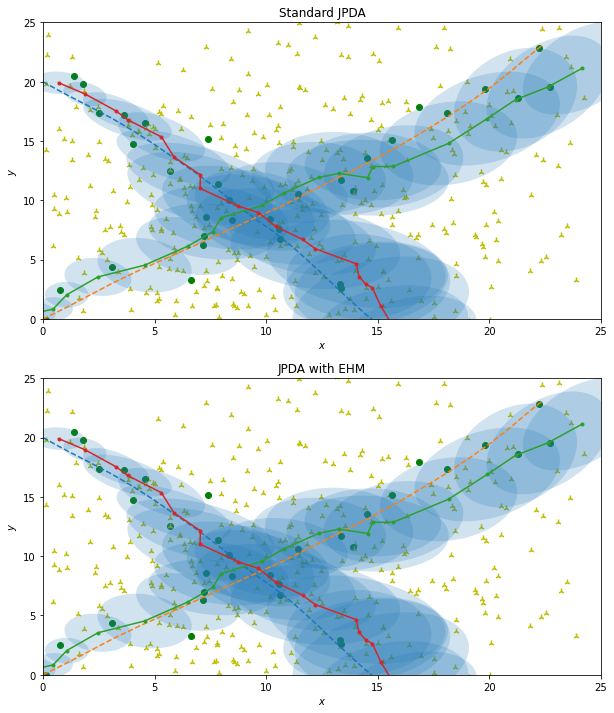

In [10]:
for track in tracks_jpda:
    # Plot track.
    axm.plot([state.state_vector[0, 0] for state in track[1:]],  # Skip plotting the prior
             [state.state_vector[2, 0] for state in track[1:]],
             marker=".")

# Plot ellipses representing the gaussian estimate state at each update.
from matplotlib.patches import Ellipse
for track in tracks_jpda:
    for state in track[1:]:  # Skip the prior
        w, v = np.linalg.eig(measurement_model.matrix()@state.covar@measurement_model.matrix().T)
        max_ind = np.argmax(w)
        min_ind = np.argmin(w)
        orient = np.arctan2(v[1, max_ind], v[0, max_ind])
        ellipse = Ellipse(xy=state.state_vector[(0, 2), 0],
                          width=2*np.sqrt(w[max_ind]),
                          height=2*np.sqrt(w[min_ind]),
                          angle=np.rad2deg(orient),
                          alpha=0.2)
        axm.add_artist(ellipse)

for track in tracks_jpda_ehm:
    # Plot track.
    axm2.plot([state.state_vector[0, 0] for state in track[1:]],  # Skip plotting the prior
             [state.state_vector[2, 0] for state in track[1:]],
             marker=".")

# Plot ellipses representing the gaussian estimate state at each update.
from matplotlib.patches import Ellipse
for track in tracks_jpda_ehm:
    for state in track[1:]:  # Skip the prior
        w, v = np.linalg.eig(measurement_model.matrix()@state.covar@measurement_model.matrix().T)
        max_ind = np.argmax(w)
        min_ind = np.argmin(w)
        orient = np.arctan2(v[1, max_ind], v[0, max_ind])
        ellipse = Ellipse(xy=state.state_vector[(0, 2), 0],
                          width=2*np.sqrt(w[max_ind]),
                          height=2*np.sqrt(w[min_ind]),
                          angle=np.rad2deg(orient),
                          alpha=0.2)
        axm2.add_artist(ellipse)
multi_fig

 ## Compare computation times

In [11]:
print("Standard JPDA: {} seconds".format(diff_jpda.total_seconds()))
print("JPDA with EHM: {} seconds".format(diff_jpda_ehm.total_seconds()))

Standard JPDA: 3.721692 seconds
JPDA with EHM: 0.885095 seconds


## Compare performance

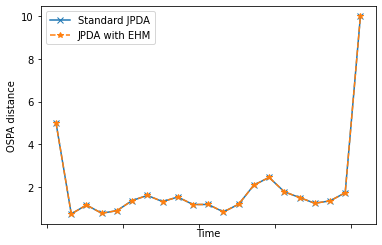

In [12]:
# Metrics for standard JPDA
metrics_jpda = metric_manager_jpda.generate_metrics()
ospa_metric_jpda = {metric for metric in metrics_jpda if metric.title == "OSPA distances"}.pop()

# Metrics for JPDA with EHM
metrics_jpda_ehm = metric_manager_jpda_ehm.generate_metrics()
ospa_metric_jpda_ehm = {metric for metric in metrics_jpda_ehm if metric.title == "OSPA distances"}.pop()

# Plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot([i.timestamp for i in ospa_metric_jpda.value], [i.value for i in ospa_metric_jpda.value], 'x-', label='Standard JPDA')
ax.plot([i.timestamp for i in ospa_metric_jpda_ehm.value], [i.value for i in ospa_metric_jpda_ehm.value], '*--', label='JPDA with EHM')
ax.set_ylabel("OSPA distance")
ax.tick_params(labelbottom=False)
_ = ax.set_xlabel("Time")
ax.legend()

References
----------
1. Bar-Shalom Y, Daum F, Huang F 2009, The Probabilistic Data Association Filter, IEEE Control Systems Magazine
2. Simon Maskell, Mark Briers, Robert Wright, "Fast mutual exclusion," Proc. SPIE 5428, Signal and Data Processing of Small Targets 2004

